#David Barnett
#Predicting the Speed of Coronal Mass Projections
#Predictions with Machine Learning

Just reading in the data

In [1]:
import pandas as pd
import numpy as np

data_dir = ("https://raw.githubusercontent.com/DavidBarnett0/" + 
            "data301_project/master/")

cme_df = pd.read_csv(data_dir + "cme.csv", 
                     index_col="startTime", 
                     parse_dates = True)

analysis_df = pd.read_csv(data_dir + "cmeanalysis.csv", 
                          index_col="occurrence_time",
                          parse_dates = True)

cme_df["note"][cme_df["note"].isna()] = ""
analysis_df["note"][analysis_df["note"].isna()] = ""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Now we are finally going to combine these two datasets into one dataset.

In [0]:
cme_combined_df = cme_df.join(analysis_df, how = "left", 
                              lsuffix="_cme", rsuffix="_analysis")

Additionally, since we want to consider time a variable in our machine learning models, we will change start time to a normal variable instead of the index.

In [0]:
cme_combined_df.reset_index(inplace = True)

Datetime types did not transfer well in the conversion to csv and back, so I will need to change the types of the date variables as well.

In [0]:
cme_combined_df["analysis_time"] = pd.to_datetime(
    cme_combined_df["analysis_time"]
)

Through our exploration in the previous notebook, we know that instruments is unnecessary. Additionally, our machine learning analyses require us to not have NA values. Due to this, I'm unfortunately dropping activeRegionNum, N/S, and E/W since there are not enough data points to justify filling in the NA values with the median. For NA values in remaining columns, we will simply drop the rows with NA because we have enough remaining rows to continue with our machine learning analyses.

In [5]:
cme_combined_df.drop(["activeRegionNum", "N/S", "E/W"], axis = 1, inplace = True)
cme_combined_df.dropna(inplace=True)
cme_combined_df.head()

,startTime,instruments,linkedEvents,note_cme,latitude,longitude,halfAngle,speed,type,note_analysis,analysis_time,time_before_analysis,time_since_last_cme
1,2015-01-02 14:36:00,SOHO: LASCO/C2 SOHO: LASCO/C3,1,Associated with a very gradual eruption in a s...,3.0,34.0,23.0,353.0,S,Reanalyzed with more C2 and STEREOA imagery,2015-01-02 23:55:00,9.316667,30.2
2,2015-01-03 03:24:00,SOHO: LASCO/C2 SOHO: LASCO/C3,0,,-49.0,-82.0,42.0,210.0,S,Source region could not be found. It's possibl...,2015-01-03 23:40:00,20.266667,12.8
3,2015-01-06 18:24:00,SOHO: LASCO/C2 SOHO: LASCO/C3,0,No source region could be found in SDO.,9.0,39.0,12.0,532.0,C,,2015-01-07 00:25:00,6.016667,87.0
4,2015-01-07 16:24:00,SOHO: LASCO/C2 SOHO: LASCO/C3 STEREO A: SECCHI...,0,SDO 193 shows indication of an eruption off th...,67.0,-102.0,20.0,579.0,C,,2015-01-08 03:10:00,10.766667,22.0
5,2015-01-09 00:00:00,SOHO: LASCO/C2 SOHO: LASCO/C3 STEREO A: SECCHI...,0,"There was this faintest CME in the SW, seen mo...",-10.0,2.0,13.0,265.0,S,,2015-01-09 05:54:00,5.900000,31.6


Now we will set our masks for the training and testing datasets for our machine learning analysis while we still have the startTime variable. The training set will have the data from 2015-2017 while the testing set will have the data from 2018-2019.

In [0]:
mask_train = cme_combined_df["startTime"] < "2018-01-01"
mask_test = cme_combined_df["startTime"] >= "2018-01-01"

Before we start, since dates won't work in our machine learning models we will turn all dates and times into variables base off the minute, hour, day, etc.

In [0]:
cme_combined_df["startTime_minutes"] = (
      cme_combined_df["startTime"].dt.year * 525600 + 
      cme_combined_df["startTime"].dt.month * 43800 +
      cme_combined_df["startTime"].dt.day * 1440 +
      cme_combined_df["startTime"].dt.hour * 24 +
      cme_combined_df["startTime"].dt.minute
 )

cme_combined_df["analysis_time_minutes"] = (
      cme_combined_df["analysis_time"].dt.year * 525600 + 
      cme_combined_df["analysis_time"].dt.month * 43800 +
      cme_combined_df["analysis_time"].dt.day * 1440 +
      cme_combined_df["analysis_time"].dt.hour * 24 +
      cme_combined_df["analysis_time"].dt.minute
 )

cme_combined_df.drop(["startTime", "analysis_time"], axis = 1, inplace = True)

In [8]:
cme_combined_df.head()

,instruments,linkedEvents,note_cme,latitude,longitude,halfAngle,speed,type,note_analysis,time_before_analysis,time_since_last_cme,startTime_minutes,analysis_time_minutes
1,SOHO: LASCO/C2 SOHO: LASCO/C3,1,Associated with a very gradual eruption in a s...,3.0,34.0,23.0,353.0,S,Reanalyzed with more C2 and STEREOA imagery,9.316667,30.2,1059131052,1059131287
2,SOHO: LASCO/C2 SOHO: LASCO/C3,0,,-49.0,-82.0,42.0,210.0,S,Source region could not be found. It's possibl...,20.266667,12.8,1059132216,1059132712
3,SOHO: LASCO/C2 SOHO: LASCO/C3,0,No source region could be found in SDO.,9.0,39.0,12.0,532.0,C,,6.016667,87.0,1059136896,1059137905
4,SOHO: LASCO/C2 SOHO: LASCO/C3 STEREO A: SECCHI...,0,SDO 193 shows indication of an eruption off th...,67.0,-102.0,20.0,579.0,C,,10.766667,22.0,1059138288,1059139402
5,SOHO: LASCO/C2 SOHO: LASCO/C3 STEREO A: SECCHI...,0,"There was this faintest CME in the SW, seen mo...",-10.0,2.0,13.0,265.0,S,,5.900000,31.6,1059140760,1059140934


Now we're going to run different machine learning models to see which performs best.

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (GradientBoostingRegressor, AdaBoostRegressor,
                              VotingRegressor, RandomForestRegressor, 
                              ExtraTreesRegressor)
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR

In [0]:
models = []
model_names = []

models.append(LinearRegression())
model_names.append("Linear Regression")

models.append(Ridge())
model_names.append("Ridge Regression")

models.append(Lasso())
model_names.append("Lasso")

models.append(ElasticNet())
model_names.append("Elastic Net")

models.append(GradientBoostingRegressor(max_depth=5))
model_names.append("Gradient Boosting")

models.append(AdaBoostRegressor())
model_names.append("AdaBoost")

models.append(RandomForestRegressor())
model_names.append("Random Forest")

models.append(ExtraTreesRegressor())
model_names.append("Extra Trees")

models.append(MLPRegressor())
model_names.append("Neural Network")

models.append(SVR())
model_names.append("Support Vector")

models.append(NuSVR())
model_names.append("Linear Support Vector")

I will now create the training and testing data sets such that the training set takes the data from 2015-2017 and the testing set takes the data from 2018-2019

In [0]:
X = cme_combined_df.drop("speed", axis = 1)
y = cme_combined_df["speed"]

X_train = X[mask_train]
y_train = y[mask_train]
X_test = X[mask_test]
y_test = y[mask_test]

ct = make_column_transformer(
  (OneHotEncoder(handle_unknown="ignore"), ["type"]),
  (TfidfVectorizer(norm = None, max_features = 200), "note_cme"),
  (TfidfVectorizer(norm = None, max_features = 200), "note_analysis"),
  (TfidfVectorizer(norm = None), "instruments"),
  remainder = "passthrough"
)

Finally, we will see which model best predicts the MSE of the testing set based on the training set. We do not need to perform any cross-validation since we have a true testing set.

In [12]:
mses = []

n = len(models)

for i in range(n):
  pipelines = []
  pipeline = make_pipeline(
      ct,
      models[i]
  )
  pipelines.append(pipeline)
  for scaler in [StandardScaler(with_mean = False), Normalizer()]:
    pipeline = make_pipeline(
      ct,
      scaler,
      models[i]
    )
    pipelines.append(pipeline)

  addition = ["", " with Standard Scaler", " with Normalizer"]
  
  for j in range(3):
    pipelines[j].fit(X_train, y_train)
    y_pred = pipelines[j].predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mses.append((model_names[i] + addition[j], int(mse)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5170165.680308646, tolerance: 6077.729348619955
  max_iter, tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11760431.068945799, tolerance: 6077.729348619955
  max_iter, tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached a

In [13]:
models_result = sorted(mses, key=lambda x: x[1])
pd.DataFrame(models_result, columns = ["model", "MSE"]).set_index("model")

,MSE
model,
Random Forest,3224
Random Forest with Standard Scaler,3280
Gradient Boosting with Standard Scaler,3294
Gradient Boosting,3324
AdaBoost,3551
AdaBoost with Standard Scaler,3692
Extra Trees,4316
Extra Trees with Standard Scaler,4418
Lasso,5683


This analysis reports that the models that minimize the mean squared error are a Random Forest Regressor with no scaler and a Gradient Boosting Regressor with a standard scaler. I will now determine the $R^2$ value of these two models.

In [14]:
rf_pipeline = make_pipeline(
    ct,
    RandomForestRegressor()
)
rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest R^2 score:", rf_r2)

gb_pipeline = make_pipeline(
    ct,
    StandardScaler(with_mean = False),
    GradientBoostingRegressor()
)
gb_pipeline.fit(X_train, y_train)
gb_pred = gb_pipeline.predict(X_test)
gb_r2 = r2_score(y_test, gb_pred)

print("Gradient Boosting R^2 score:", gb_r2)

Random Forest R^2 score: 0.8282235904534659
Gradient Boosting R^2 score: 0.8057110247931129


Both of these have high $R^2$ values, which means our models were very successful.

I will now plot the true speeds against predicted speeds from these two models, with a line through the middle indicating where the points would fall if they were all perfect predictions.

In [0]:
i  = [x for x in range(1000)]
y_eq_x = pd.DataFrame({"x": i, "y": i})

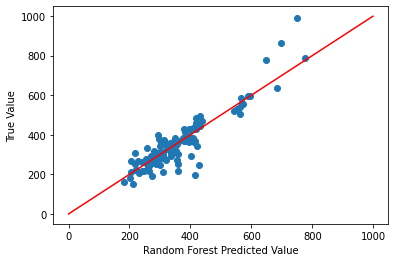

In [16]:
import matplotlib.pyplot as plt

rf_df = pd.DataFrame({"True Value": y_test, 
                      "Random Forest Predicted Value": rf_pred})

plt.scatter(x = rf_df["Random Forest Predicted Value"],
            y = rf_df["True Value"])

plt.ylabel("True Value")
plt.xlabel("Random Forest Predicted Value")

plt.plot(y_eq_x["x"], y_eq_x["y"], color = "red")

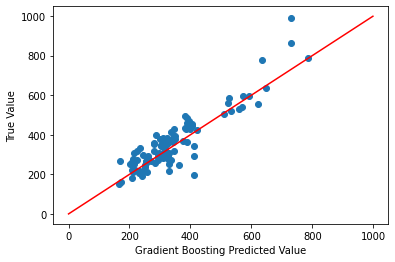

In [17]:
gb_df = pd.DataFrame({"True Value": y_test, 
                      "Gradient Boosting Predicted Value": gb_pred})

plt.scatter(x = gb_df["Gradient Boosting Predicted Value"],
            y = gb_df["True Value"])

plt.ylabel("True Value")
plt.xlabel("Gradient Boosting Predicted Value")

plt.plot(y_eq_x["x"], y_eq_x["y"], color = "red")

Finally, Random Forest allows us to check Feature Importance to see which variables had a highest impact on CME speed.

,Importance
Feature,
type,0.777568
time_before_analysis,0.157595
note_cme,0.017227
halfAngle,0.009439
note_analysis,0.007312
longitude,0.006707
time_since_last_cme,0.005375
latitude,0.004764
startTime_minutes,0.004632


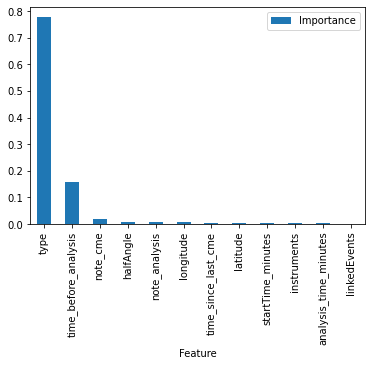

In [18]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer

def row_to_dict(Xtrain, ytrain=None):
    return Xtrain.apply(dict, axis=1)

ft = FunctionTransformer(row_to_dict, validate=False)
dv = DictVectorizer()
rf = RandomForestRegressor()

feature_pipeline = make_pipeline(
    ft,
    dv,
    rf
)
feature_pipeline.fit(X_train, y_train)

feature_importances = list(zip(dv.feature_names_, rf.feature_importances_))

new_importances = {}
to_remove = []
for i in range(len(feature_importances)):
    feature = feature_importances[i][0]
    score = feature_importances[i][1]
    if "=" in feature:
        to_remove.append(feature_importances[i])
        split = feature.split("=")
        if split[0] in list(new_importances.keys()):
            new_importances[split[0]] += score
        else:
            new_importances[split[0]] = score

for val in to_remove:
    feature_importances.remove(val)
    
for key in list(new_importances.keys()):
    feature_importances.append((key, new_importances[key]))

feature_importances = sorted(feature_importances, 
                             key=lambda x: x[1], reverse = True)

importances = pd.DataFrame.from_records(feature_importances, 
                                        columns = ["Feature", "Importance"]
                                        ).set_index("Feature")
display(importances)
importances.plot.bar()

According to our feature importance analysis, the type of CME is by far the most important feature, which is unsurprising considering the boxplot of speed grouped by type in the data exploration section. Additionally, the time elapsed between when the CME occurred and when the analysis occurred also has a non-negligible correlation with speed, indicating that faster CMEs are analyzed quicker. This results seems correct based off our exploratory analyses in the previous notebook.